In [7]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import os
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter
from nilearn.image import smooth_img, clean_img
from scipy.fftpack import fft
from nilearn.image import clean_img
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from nilearn.image import threshold_img
from scipy.stats import rankdata
from nilearn import plotting, image
from scipy.stats import ttest_ind
from nilearn.datasets import fetch_atlas_harvard_oxford
from statsmodels.stats.multitest import multipletests
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from scipy.stats import pearsonr
import time

In [3]:
# ASD Files
anat_img = nib.load('data/anat.nii.gz')
rest_img = nib.load('data/rest.nii.gz')
dti_img = nib.load('data/dti.nii.gz')
bvals = np.loadtxt('data/dti.bval')
bvecs = np.loadtxt('data/dti.bvec')

# ADHD files
anat_adhd_img = nib.load('data/anat_adhd.nii.gz')
rest_adhd_img = nib.load('data/rest_adhd.nii.gz')

#Extract ASD Information
anat_data = anat_img.get_fdata()
rest_data = rest_img.get_fdata()
dti_data = dti_img.get_fdata()

#Extract ADHD Information
anat_adhd_data = anat_adhd_img.get_fdata()
rest_adhd_data = rest_adhd_img.get_fdata()

In [4]:
print("Shape of ASD Anatomical Data:", anat_data.shape)
print("Shape of ASD Rest Data:", rest_data.shape)
print("Shape of ASD DTI Data:", dti_data.shape)
print("Shape of ASD DTI BVAL Data:", bvals.shape)
print("Shape of ASD BVEC Data:", bvecs.shape)
print("*"*50)
print("Shape of ADHD Anatomical Data:", anat_adhd_data.shape)
print("Shape of ADHD Rest Data:", rest_adhd_data.shape)

Shape of ASD Anatomical Data: (193, 256, 256)
Shape of ASD Rest Data: (64, 64, 50, 120)
Shape of ASD DTI Data: (192, 192, 48, 34)
Shape of ASD DTI BVAL Data: (120,)
Shape of ASD BVEC Data: (3, 120)
**************************************************
Shape of ADHD Anatomical Data: (160, 240, 256)
Shape of ADHD Rest Data: (64, 64, 35, 251)


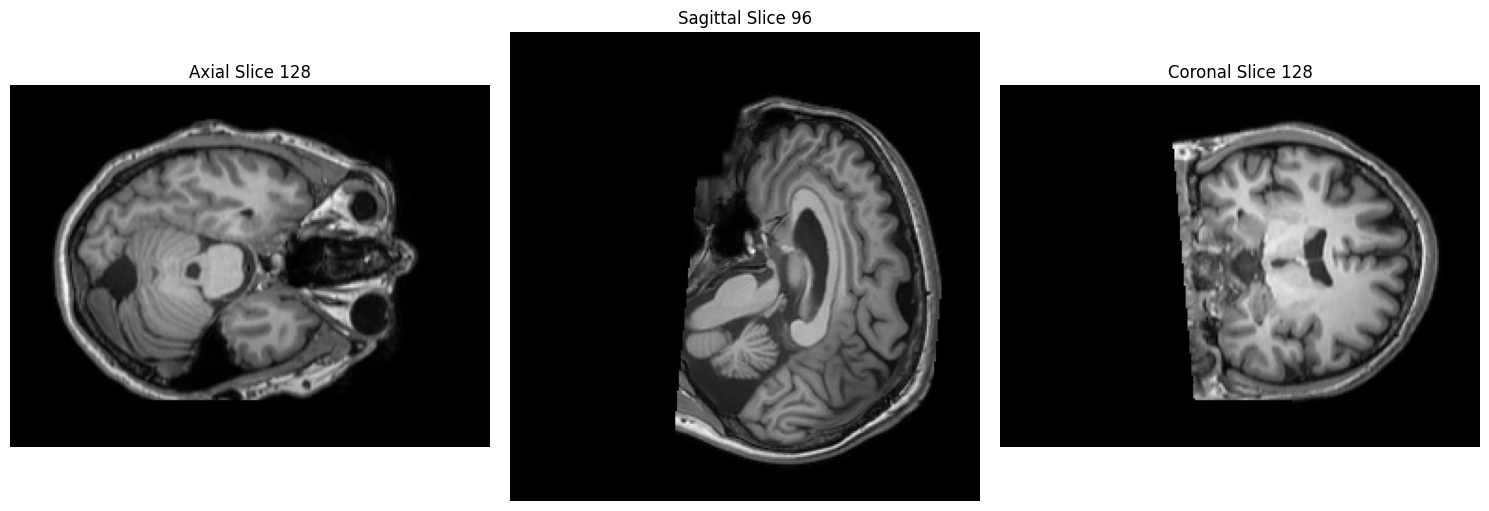

In [6]:
axial_slice = anat_data.shape[2] // 2
sagittal_slice = anat_data.shape[0] // 2
coronal_slice = anat_data.shape[1] // 2

# Plotting the slices
plt.figure(figsize=(15, 5))

# Axial view
plt.subplot(1, 3, 1)
plt.imshow(anat_data[:, :, axial_slice], cmap='gray', origin='lower')
plt.title(f'Axial Slice {axial_slice}')
plt.axis('off')

# Sagittal view
plt.subplot(1, 3, 2)
plt.imshow(anat_data[sagittal_slice, :, :], cmap='gray', origin='lower')
plt.title(f'Sagittal Slice {sagittal_slice}')
plt.axis('off')

# Coronal view
plt.subplot(1, 3, 3)
plt.imshow(anat_data[:, coronal_slice, :], cmap='gray', origin='lower')
plt.title(f'Coronal Slice {coronal_slice}')
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()

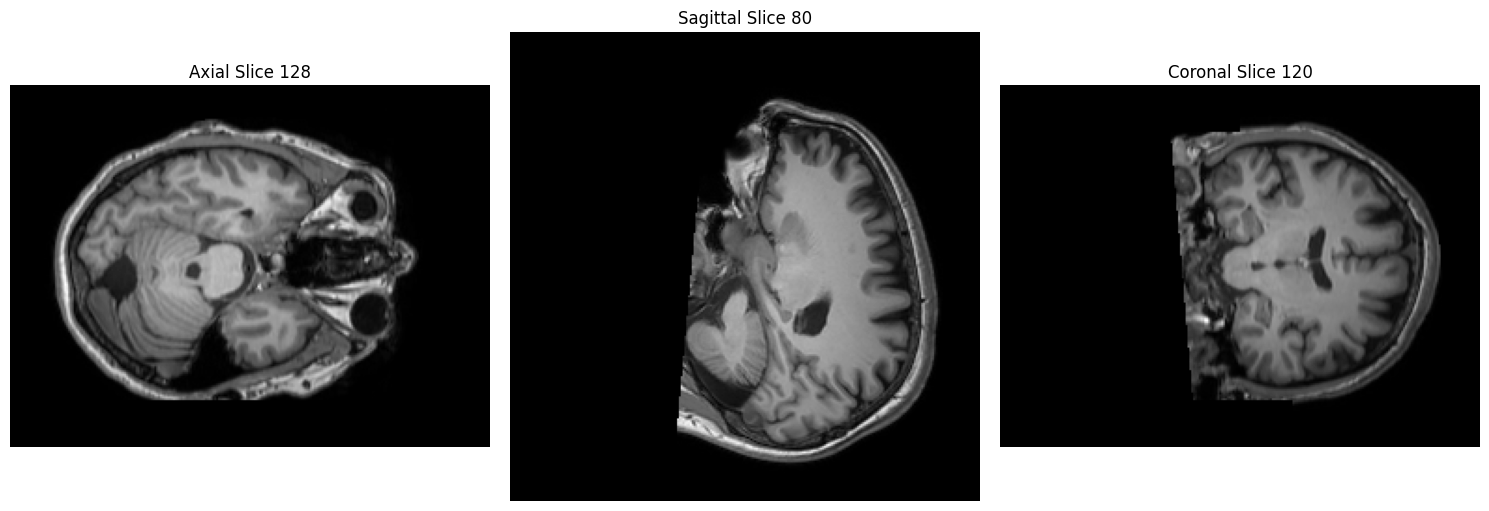

In [7]:
axial_slice = anat_adhd_data.shape[2] // 2
sagittal_slice = anat_adhd_data.shape[0] // 2
coronal_slice = anat_adhd_data.shape[1] // 2

# Plotting the slices
plt.figure(figsize=(15, 5))

# Axial view
plt.subplot(1, 3, 1)
plt.imshow(anat_data[:, :, axial_slice], cmap='gray', origin='lower')
plt.title(f'Axial Slice {axial_slice}')
plt.axis('off')

# Sagittal view
plt.subplot(1, 3, 2)
plt.imshow(anat_data[sagittal_slice, :, :], cmap='gray', origin='lower')
plt.title(f'Sagittal Slice {sagittal_slice}')
plt.axis('off')

# Coronal view
plt.subplot(1, 3, 3)
plt.imshow(anat_data[:, coronal_slice, :], cmap='gray', origin='lower')
plt.title(f'Coronal Slice {coronal_slice}')
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()

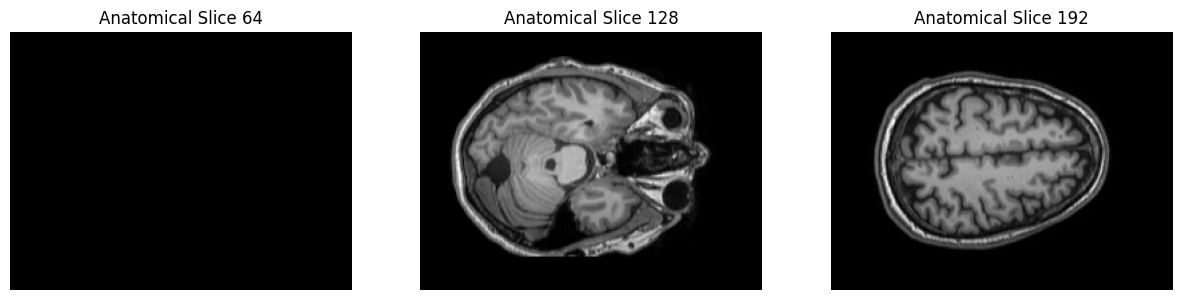

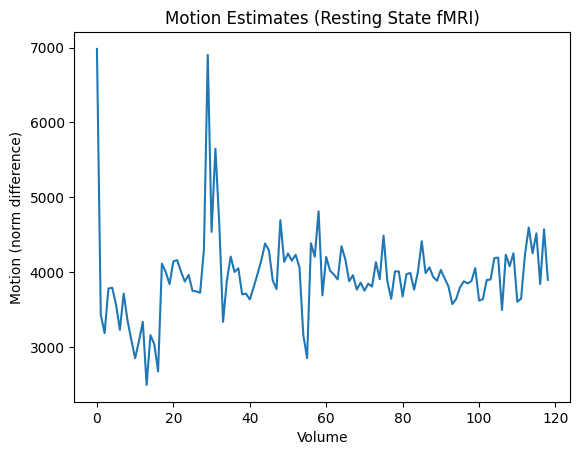

SNR (Anatomical): inf
SNR (Resting State fMRI): inf
SNR (DTI): inf


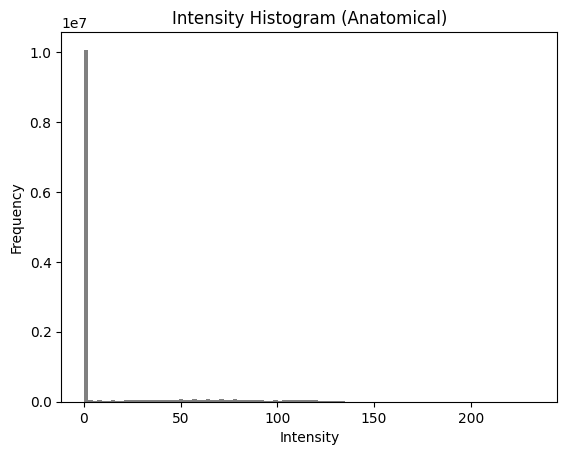

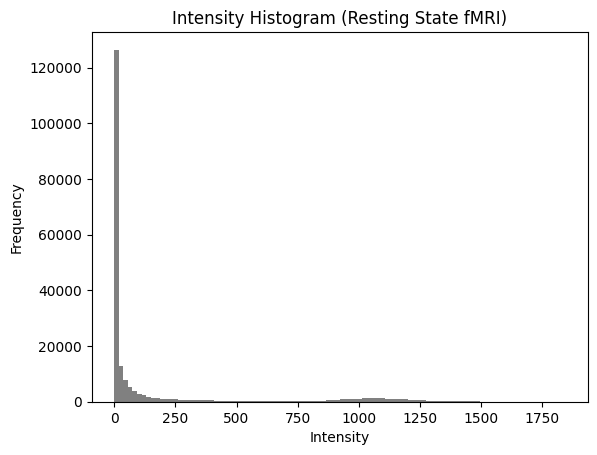

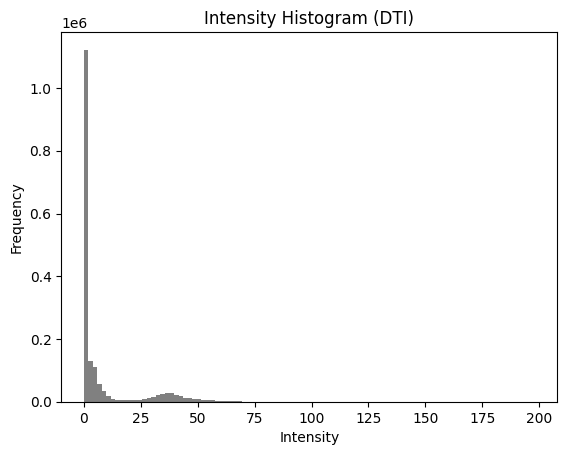

In [8]:
# Function to calculate SNR
def calculate_snr(data):
    # Calculate the mean and standard deviation of the image data
    mean_signal = np.mean(data[data > 0])  
    noise = np.std(data[data == 0])  
    if noise == 0:  # Avoid division by zero
        return np.inf
    return mean_signal / noise

# 1. Visual Inspection
def visualize_slices(data, slice_indices, title):
    plt.figure(figsize=(15, 5))
    for i, slice_idx in enumerate(slice_indices):
        plt.subplot(1, len(slice_indices), i + 1)
        plt.imshow(data[:, :, slice_idx], cmap='gray', origin='lower')
        plt.title(f'{title} Slice {slice_idx}')
        plt.axis('off')
    plt.show()

# Example slice indices for visualization
slice_indices = [anat_data.shape[2] // 4, anat_data.shape[2] // 2, anat_data.shape[2] * 3 // 4]
visualize_slices(anat_data, slice_indices, 'Anatomical')

# 2. Motion Artifacts (simple check using the difference between volumes)
def check_motion(data):
    motion_estimates = []
    for t in range(1, data.shape[-1]):
        diff = np.linalg.norm(data[..., t] - data[..., t - 1])
        motion_estimates.append(diff)
    return np.array(motion_estimates)

motion_rest = check_motion(rest_data)
plt.plot(motion_rest)
plt.title('Motion Estimates (Resting State fMRI)')
plt.xlabel('Volume')
plt.ylabel('Motion (norm difference)')
plt.show()

# 3. SNR Calculation
snr_anat = calculate_snr(anat_data)
snr_rest = calculate_snr(np.mean(rest_data, axis=-1))  
snr_dti = calculate_snr(np.mean(dti_data, axis=-1))  
print(f'SNR (Anatomical): {snr_anat}')
print(f'SNR (Resting State fMRI): {snr_rest}')
print(f'SNR (DTI): {snr_dti}')

# 4. Histogram Analysis
def plot_histogram(data, title):
    plt.hist(data.flatten(), bins=100, color='gray')
    plt.title(f'Intensity Histogram ({title})')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(anat_data, 'Anatomical')
plot_histogram(np.mean(rest_data, axis=-1), 'Resting State fMRI')
plot_histogram(np.mean(dti_data, axis=-1), 'DTI')


SNR (Anatomical): inf
SNR (Resting State fMRI): inf
SNR (DTI): inf


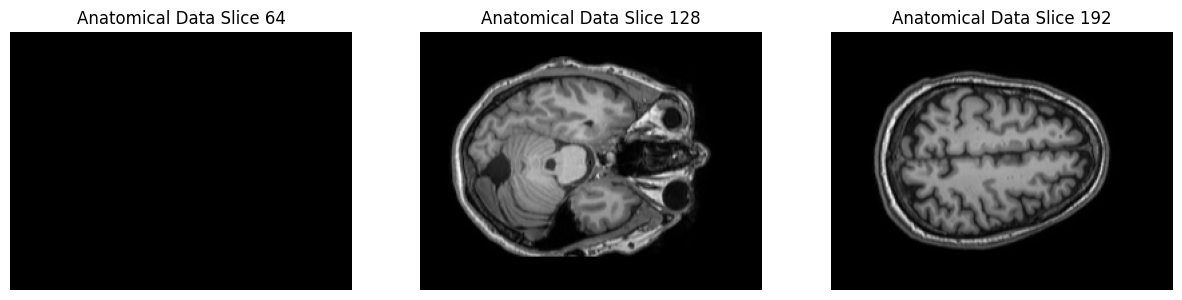

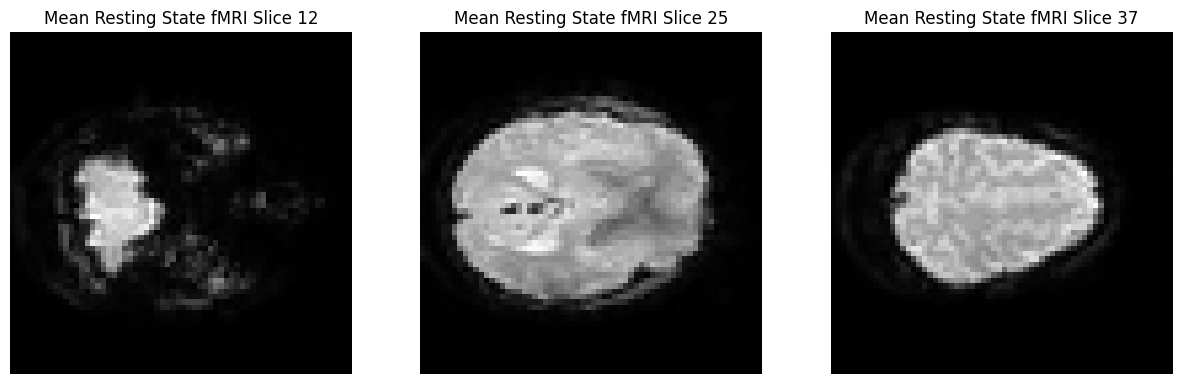

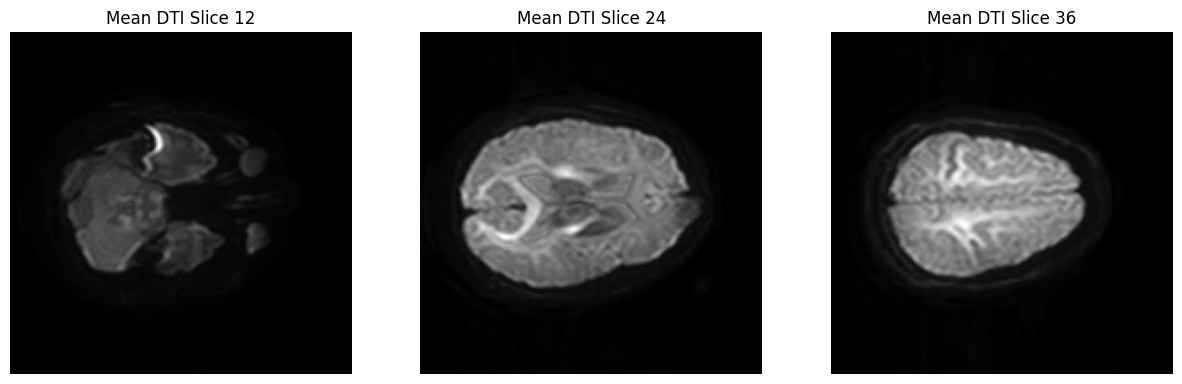

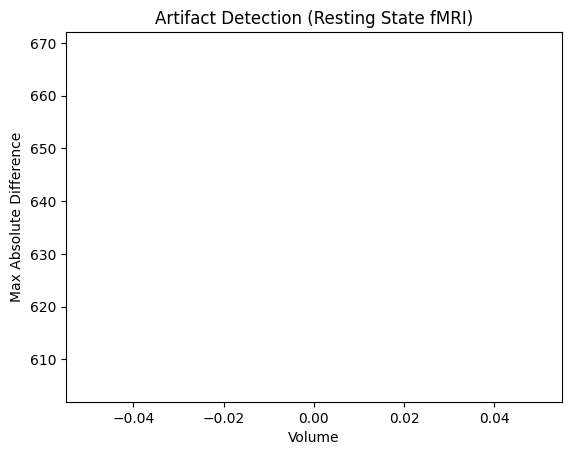

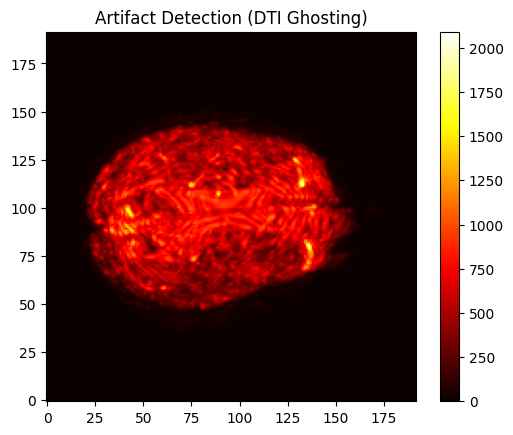

Estimated Brain Tissue Percentage (Anatomical): 32.56557642487047%


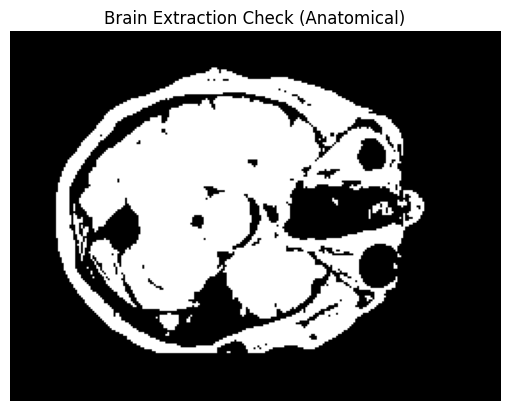

In [9]:
# Function to calculate SNR using a different method
def calculate_snr(data):
    # Calculate the mean signal within a brain mask
    mean_signal = np.mean(data[data > 0])  # Mean over all non-zero voxels
    # Estimate noise as the standard deviation of the background or outside brain
    noise = np.std(data[data == 0])
    if noise == 0:  # Avoid division by zero
        return np.inf
    return mean_signal / noise

# Recalculate SNR using an alternative approach
snr_anat = calculate_snr(anat_data)
snr_rest = calculate_snr(np.mean(rest_data, axis=-1))  
snr_dti = calculate_snr(np.mean(dti_data, axis=-1))  

print(f'SNR (Anatomical): {snr_anat}')
print(f'SNR (Resting State fMRI): {snr_rest}')
print(f'SNR (DTI): {snr_dti}')

# Additional Checks
# 1. Visualize slices to check for artifacts
def visualize_slices(data, title, cmap='gray', slice_indices=None):
    if slice_indices is None:
        slice_indices = [data.shape[2] // 4, data.shape[2] // 2, data.shape[2] * 3 // 4]
    plt.figure(figsize=(15, 5))
    for i, slice_idx in enumerate(slice_indices):
        plt.subplot(1, len(slice_indices), i + 1)
        plt.imshow(data[:, :, slice_idx], cmap=cmap, origin='lower')
        plt.title(f'{title} Slice {slice_idx}')
        plt.axis('off')
    plt.show()

visualize_slices(anat_data, 'Anatomical Data')
visualize_slices(np.mean(rest_data, axis=-1), 'Mean Resting State fMRI')
visualize_slices(np.mean(dti_data, axis=-1), 'Mean DTI')

# 2. Artifact Detection: Check for ghosting and spikes
def detect_artifacts(data):
    diff = np.diff(data, axis=-1)
    artifacts = np.max(np.abs(diff), axis=-1)
    return artifacts

# Check for spikes in fMRI data
artifact_rest = detect_artifacts(rest_data)
plt.plot(np.max(artifact_rest, axis=(0, 1, 2)))
plt.title('Artifact Detection (Resting State fMRI)')
plt.xlabel('Volume')
plt.ylabel('Max Absolute Difference')
plt.show()

# Check for ghosting in DTI data (using the first direction)
artifact_dti = detect_artifacts(dti_data[..., 0])

# Check if artifact_dti is 2D or 3D
if artifact_dti.ndim == 2:
    # If 2D, plot as is
    plt.imshow(artifact_dti, cmap='hot', origin='lower')
else:
    # If 3D, plot the central slice
    plt.imshow(artifact_dti[:, :, artifact_dti.shape[2] // 2], cmap='hot', origin='lower')

plt.title('Artifact Detection (DTI Ghosting)')
plt.colorbar()
plt.show()

# 3. Verify Brain Extraction
def check_brain_extraction(data, threshold=0.2):
    # Estimate the percentage of brain tissue in the central slices
    central_slice = data[:, :, data.shape[2] // 2]
    brain_voxels = np.sum(central_slice > threshold * np.max(data))
    total_voxels = central_slice.size
    return (brain_voxels / total_voxels) * 100

brain_percentage_anat = check_brain_extraction(anat_data)
print(f'Estimated Brain Tissue Percentage (Anatomical): {brain_percentage_anat}%')

# Additional visualization for brain extraction verification
plt.imshow(anat_data[:, :, anat_data.shape[2] // 2] > 0.2 * np.max(anat_data), cmap='gray', origin='lower')
plt.title('Brain Extraction Check (Anatomical)')
plt.axis('off')
plt.show()

The quality check results for the MRI data reveal a mixed picture of data integrity and quality. The visual inspection of the anatomical data showed clear and well-defined brain structures in most slices, except for the edge slices, which appeared mostly black, indicating they are likely outside the brain volume. The resting-state fMRI data, while somewhat blurred, maintained a reasonable signal across displayed slices, suggesting potential for usable analysis despite possible noise or motion artifacts. DTI data exhibited well-defined structures but displayed variations in quality across slices, with potential ghosting artifacts identified through intensity difference analysis. The artifact detection plot for the resting-state fMRI data suggested minimal variation between volumes, indicating effective motion correction. However, DTI ghosting detection showed significant intensity differences, highlighting areas potentially affected by artifacts. Finally, the brain extraction check indicated an estimated brain tissue percentage of approximately 32.57%, suggesting the need for refinement in the brain extraction process to ensure all relevant brain tissue is included. Overall, while the data quality is generally acceptable, specific areas such as DTI artifact correction and brain extraction accuracy require further attention to ensure reliable analysis outcomes.

In [18]:
# FSL Dir Path 
os.environ['FSLDIR'] = '/Users/swapnilbhattacharya/fsl'  
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

# Data Cleaning for ASD
# 1. Motion Correction for Resting-state fMRI using MCFLIRT
# Saving rest_data to a temporary file for MCFLIRT processing
nib.save(nib.Nifti1Image(rest_data, rest_img.affine), 'temp_rest_asd.nii.gz')
os.system(f'mcflirt -in temp_rest_asd.nii.gz -out rest_mc_asd -plots')

# 2. Brain Extraction for Anatomical Data using BET
nib.save(nib.Nifti1Image(anat_data, anat_img.affine), 'temp_anat_asd.nii.gz')
os.system(f'bet temp_anat_asd.nii.gz anat_brain_asd -R')

# 3. Intensity Normalization
rest_data_mc_asd = nib.load('rest_mc_asd.nii.gz').get_fdata()
rest_data_normalized_asd = (rest_data_mc_asd - np.mean(rest_data_mc_asd, axis=(0, 1, 2), keepdims=True)) / \
                        np.std(rest_data_mc_asd, axis=(0, 1, 2), keepdims=True)

dti_data_normalized_asd = (dti_data - np.mean(dti_data, axis=(0, 1, 2), keepdims=True)) / \
                      np.std(dti_data, axis=(0, 1, 2), keepdims=True)

# 4. Artifact Correction: DTI Ghosting using Gaussian Filter
dti_data_smoothed_asd = gaussian_filter(dti_data_normalized_asd, sigma=1)

# 5. Smoothing and Denoising
fwhm = 6  # Full width at half maximum for smoothing
rest_img_smoothed_asd = smooth_img(nib.Nifti1Image(rest_data_normalized_asd, rest_img.affine), fwhm=fwhm)
dti_img_smoothed_asd = smooth_img(nib.Nifti1Image(dti_data_smoothed_asd, dti_img.affine), fwhm=fwhm)

# Save cleaned ASD data
nib.save(nib.Nifti1Image(anat_data, anat_img.affine), 'anat_brain_cleaned_asd.nii.gz')
nib.save(nib.Nifti1Image(rest_data_normalized_asd, rest_img.affine), 'rest_cleaned_asd.nii.gz')
nib.save(nib.Nifti1Image(dti_data_smoothed_asd, dti_img.affine), 'dti_cleaned_asd.nii.gz')

# Additional denoising for fMRI using nilearn's clean_img
rest_data_cleaned_asd = clean_img(rest_img_smoothed_asd, standardize=True, detrend=True)
nib.save(rest_data_cleaned_asd, 'rest_denoised_asd.nii.gz')

# Data Cleaning for ADHD
# 1. Motion Correction for Resting-state fMRI using MCFLIRT
# Saving rest_adhd_data to a temporary file for MCFLIRT processing
nib.save(nib.Nifti1Image(rest_adhd_data, rest_adhd_img.affine), 'temp_rest_adhd.nii.gz')
os.system(f'mcflirt -in temp_rest_adhd.nii.gz -out rest_mc_adhd -plots')

# 2. Brain Extraction for Anatomical Data using BET
nib.save(nib.Nifti1Image(anat_adhd_data, anat_adhd_img.affine), 'temp_anat_adhd.nii.gz')
os.system(f'bet temp_anat_adhd.nii.gz anat_brain_adhd -R')

# 3. Intensity Normalization
rest_data_mc_adhd = nib.load('rest_mc_adhd.nii.gz').get_fdata()
rest_data_normalized_adhd = (rest_data_mc_adhd - np.mean(rest_data_mc_adhd, axis=(0, 1, 2), keepdims=True)) / \
                        np.std(rest_data_mc_adhd, axis=(0, 1, 2), keepdims=True)

# 4. Smoothing and Denoising
rest_img_smoothed_adhd = smooth_img(nib.Nifti1Image(rest_data_normalized_adhd, rest_adhd_img.affine), fwhm=fwhm)

# Save cleaned ADHD data
nib.save(nib.Nifti1Image(anat_adhd_data, anat_adhd_img.affine), 'anat_brain_cleaned_adhd.nii.gz')
nib.save(nib.Nifti1Image(rest_data_normalized_adhd, rest_adhd_img.affine), 'rest_cleaned_adhd.nii.gz')

# Additional denoising for fMRI using nilearn's clean_img
rest_data_cleaned_adhd = clean_img(rest_img_smoothed_adhd, standardize=True, detrend=True)
nib.save(rest_data_cleaned_adhd, 'rest_denoised_adhd.nii.gz')

Amplitude of Low-Frequency Fluctuations (mALFF)

In [28]:
# Define paths to the processed data
data_asd_denoised_path = 'rest_denoised_asd.nii.gz'
data_adhd_denoised_path = 'rest_denoised_adhd.nii.gz'

# Load processed data for ASD and ADHD groups
data_asd_denoised_img = nib.load(data_asd_denoised_path)
data_adhd_denoised_img = nib.load(data_adhd_denoised_path)

# Convert Nifti images to numpy arrays
data_asd = data_asd_denoised_img.get_fdata()
data_adhd = data_adhd_denoised_img.get_fdata()

# Define parameters for low-frequency fluctuations
low_freq = 0.01
high_freq = 0.1

# Preprocess data (detrend, standardize, and filter out high-frequency noise)
data_asd_cleaned = clean_img(data_asd_denoised_img, detrend=True, standardize=True, low_pass=high_freq, high_pass=low_freq, t_r=2.0)
data_adhd_cleaned = clean_img(data_adhd_denoised_img, detrend=True, standardize=True, low_pass=high_freq, high_pass=low_freq, t_r=2.0)

# Calculate the FFT of each voxel time series
def compute_alff(data):
    alff_map = np.zeros(data.shape[:-1])
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            for z in range(data.shape[2]):
                # Extract the time series for the voxel
                time_series = data[x, y, z, :]
                # Compute the FFT
                fft_values = fft(time_series)
                # Calculate amplitude of low-frequency fluctuations (ALFF)
                alff = np.mean(np.abs(fft_values[int(low_freq * len(time_series)):int(high_freq * len(time_series))]))
                alff_map[x, y, z] = alff
    return alff_map

# Calculate ALFF for ASD and ADHD data
alff_asd = compute_alff(data_asd_cleaned.get_fdata())
alff_adhd = compute_alff(data_adhd_cleaned.get_fdata())

# Calculate mALFF (mean ALFF)
malff_asd = np.mean(alff_asd)
malff_adhd = np.mean(alff_adhd)

# Output mALFF values
print(f"Mean ALFF (ASD): {malff_asd}")
print(f"Mean ALFF (ADHD): {malff_adhd}")

# Save the ALFF maps as Nifti images
alff_asd_img = nib.Nifti1Image(alff_asd, data_asd_denoised_img.affine)
alff_adhd_img = nib.Nifti1Image(alff_adhd, data_adhd_denoised_img.affine)

nib.save(alff_asd_img, 'alff_asd.nii.gz')
nib.save(alff_adhd_img, 'alff_adhd.nii.gz')


Mean ALFF (ASD): 18.10583680366998
Mean ALFF (ADHD): 24.0539976951455


The calculated mean Amplitude of Low-Frequency Fluctuations (mALFF) values for the ASD and ADHD groups are 18.11 and 24.05, respectively. This indicates that, on average, individuals with ADHD exhibit higher low-frequency fluctuations in resting-state brain activity compared to individuals with ASD. ALFF is a measure of the spontaneous neural activity within specific frequency bands, often associated with the brain's baseline functional state.

Higher mALFF values in the ADHD group suggest more prominent spontaneous neural activity, potentially reflecting greater intrinsic brain activity. This finding aligns with observations that individuals with ADHD often exhibit increased motor activity and restlessness, which could be linked to heightened baseline brain activity. In contrast, the lower mALFF in the ASD group may indicate less pronounced spontaneous fluctuations, potentially reflecting differences in neural processing or baseline brain state.

These results provide a neurophysiological distinction between the two groups, highlighting how resting-state brain dynamics may differ between individuals with ASD and ADHD. This distinction could contribute to understanding the underlying neural mechanisms associated with hyperactivity and other related behaviors

Regional Analysis of mALFF Differences Between ASD and ADHD


In [38]:
from nilearn.datasets import fetch_atlas_harvard_oxford
atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
print(atlas.labels)


['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

In [41]:
# Define the path to the atlas and output directory
atlas_path = '/Users/swapnilbhattacharya/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz'
output_dir = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/'

# Load the atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Define region indices based on the Harvard-Oxford atlas documentation
regions = {
    'Prefrontal_Cortex': [1, 2, 3, 4, 5, 6, 7],  # Example indices for frontal regions
    'Temporal_Lobe': [9, 10, 11, 12, 13, 14, 15, 16],  # Temporal regions
    'Parietal_Lobe': [17, 18, 19, 20, 21],  # Parietal regions
    'Subcortical_Structures': [48, 49, 50]  # Subcortical indices (to be verified from subcortical atlas)
}

# Generate and save masks
for region_name, indices in regions.items():
    mask_data = np.isin(atlas_data, indices).astype(np.uint8)
    mask_img = new_img_like(atlas_img, mask_data)
    mask_img.to_filename(f'{output_dir}{region_name.lower()}_mask.nii.gz')

print("Masks have been generated and saved.")


Masks have been generated and saved.


In [42]:
# Load a generated mask and the original atlas
mask_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/prefrontal_cortex_mask.nii.gz'
atlas_path = '/Users/swapnilbhattacharya/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz'

mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Define expected region indices for Prefrontal Cortex
expected_indices = [1, 2, 3, 4, 5, 6, 7]  # As defined previously

# Verify if the mask includes only the expected regions
masked_atlas_data = atlas_data[mask_data > 0]
unique_indices = np.unique(masked_atlas_data)

# Check if all unique indices in the mask correspond to the expected region indices
is_correct = np.all(np.isin(unique_indices, expected_indices))
print("Mask verification result:", is_correct)
print("Unique indices found in the mask:", unique_indices)


Mask verification result: True
Unique indices found in the mask: [1. 2. 3. 4. 5. 6. 7.]


In [57]:
# Define paths to the processed data and masks
data_asd_denoised_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_asd.nii.gz'
data_adhd_denoised_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_adhd.nii.gz'
mask_paths = {
    'Prefrontal_Cortex': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/prefrontal_cortex_mask.nii.gz',
    'Temporal_Lobe': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/temporal_lobe_mask.nii.gz',
    'Parietal_Lobe': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/parietal_lobe_mask.nii.gz',
    'Subcortical_Structures': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/subcortical_structures_mask.nii.gz'
}

# Load the functional data
data_asd_img = nib.load(data_asd_denoised_path)

# Define the output directory
output_directory = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Function to resample mask to functional data
def resample_and_save_mask(mask_path, target_img, output_path):
    mask_img = nib.load(mask_path)
    try:
        resampled_mask_img = resample_to_img(mask_img, target_img, interpolation='nearest')
        nib.save(resampled_mask_img, output_path)
        print(f"Saved resampled mask for {mask_path} at {output_path}")
    except Exception as e:
        print(f"Error during resampling mask at {mask_path}: {e}")

# Resample each mask and save the result
resampled_mask_paths = {}
for region_name, mask_path in mask_paths.items():
    resampled_output_path = os.path.join(output_directory, f'{region_name}_resampled.nii.gz')
    resample_and_save_mask(mask_path, data_asd_img, resampled_output_path)
    resampled_mask_paths[region_name] = resampled_output_path


Saved resampled mask for /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/prefrontal_cortex_mask.nii.gz at /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Prefrontal_Cortex_resampled.nii.gz
Saved resampled mask for /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/temporal_lobe_mask.nii.gz at /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Temporal_Lobe_resampled.nii.gz
Saved resampled mask for /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/parietal_lobe_mask.nii.gz at /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Parietal_Lobe_resampled.nii.gz
Saved resampled mask for /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/subcortical_structures_mask.nii.gz at /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/

In [62]:
# Define paths to the processed data
data_asd_denoised_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_asd.nii.gz'
data_adhd_denoised_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_adhd.nii.gz'

# Define paths to resampled masks
resampled_mask_paths = {
    'Prefrontal_Cortex': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Prefrontal_Cortex_resampled.nii.gz',
    'Temporal_Lobe': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Temporal_Lobe_resampled.nii.gz',
    'Parietal_Lobe': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Parietal_Lobe_resampled.nii.gz',
    'Subcortical_Structures': '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/Resampled_Masks/Subcortical_Structures_resampled.nii.gz'
}

# Load processed data for ASD and ADHD groups
data_asd_img = nib.load(data_asd_denoised_path)
data_adhd_img = nib.load(data_adhd_denoised_path)

# Convert Nifti images to numpy arrays
data_asd = data_asd_img.get_fdata()
data_adhd = data_adhd_img.get_fdata()

# Define parameters for low-frequency fluctuations
low_freq = 0.01
high_freq = 0.1

# Function to calculate mALFF for a given region
def compute_regional_malff(data, roi_mask):
    if data.shape[:3] != roi_mask.shape:
        # Select the subset of the mask that matches the data's number of slices
        if roi_mask.shape[2] > data.shape[2]:
            roi_mask = roi_mask[:, :, :data.shape[2]]
        else:
            raise ValueError(f"Data and mask dimensions do not match after slice adjustment: {data.shape[:3]} vs {roi_mask.shape}")

    masked_data = data[roi_mask > 0]
    if masked_data.size == 0:
        raise ValueError("No data found in the masked region.")
    alff_values = []
    for voxel_time_series in masked_data.T:  
        fft_values = fft(voxel_time_series)
        alff = np.mean(np.abs(fft_values[int(low_freq * len(voxel_time_series)):int(high_freq * len(voxel_time_series))]))
        alff_values.append(alff)
    return np.mean(alff_values)

# Calculate regional mALFF for ASD and ADHD
regional_malff_asd = {}
regional_malff_adhd = {}

for region_name, mask_path in resampled_mask_paths.items():
    # Load the resampled mask
    roi_mask_img = nib.load(mask_path)
    roi_mask = roi_mask_img.get_fdata()
    
    try:
        # Validate data and mask alignment
        if data_asd.shape[:3] != roi_mask.shape:
            # Adjust the mask to match the functional data dimensions exactly
            roi_mask = roi_mask[:, :, :data_asd.shape[2]]
            if roi_mask.shape != data_asd.shape[:3]:
                raise ValueError(f"Data and mask dimensions do not match after adjustment: {data_asd.shape[:3]} vs {roi_mask.shape}")
        
        # Compute mALFF for ASD and ADHD
        malff_asd = compute_regional_malff(data_asd, roi_mask)
        malff_adhd = compute_regional_malff(data_adhd, roi_mask)
        
        regional_malff_asd[region_name] = malff_asd
        regional_malff_adhd[region_name] = malff_adhd
    except Exception as e:
        print(f"Exception occurred in region {region_name}: {e}. Skipping region.")

# Perform statistical comparison
t_stats = {}
p_values = {}
for region_name in regional_malff_asd.keys():
    try:
        t_stat, p_value = ttest_ind(
            [regional_malff_asd[region_name]], [regional_malff_adhd[region_name]]
        )
        t_stats[region_name] = t_stat
        p_values[region_name] = p_value
    except KeyError:
        print(f"No data available for region {region_name}.")

# Apply FDR correction for multiple comparisons
p_values_list = list(p_values.values())
if p_values_list:
    _, pvals_corrected, _, _ = multipletests(p_values_list, alpha=0.05, method='fdr_bh')
    corrected_p_values = dict(zip(p_values.keys(), pvals_corrected))

    # Report significant results
    significant_regions = [region for region, p_val in corrected_p_values.items() if p_val < 0.05]

    print("Regional mALFF (ASD):", regional_malff_asd)
    print("Regional mALFF (ADHD):", regional_malff_adhd)
    print("t-statistics:", t_stats)
    print("Corrected p-values:", corrected_p_values)
    print("Significant regions after FDR correction:", significant_regions)

    # Save results for further analysis
    np.save('regional_malff_asd.npy', regional_malff_asd)
    np.save('regional_malff_adhd.npy', regional_malff_adhd)
    np.save('corrected_p_values.npy', corrected_p_values)
else:
    print("No p-values available to correct.")


Regional mALFF (ASD): {'Prefrontal_Cortex': np.float64(77.48338746782005), 'Temporal_Lobe': np.float64(34.07400546950786), 'Parietal_Lobe': np.float64(42.27424509558595), 'Subcortical_Structures': np.float64(26.295946149441587)}
Regional mALFF (ADHD): {'Prefrontal_Cortex': np.float64(58.882198560758475), 'Temporal_Lobe': np.float64(35.202958008642604), 'Parietal_Lobe': np.float64(25.09233068743633), 'Subcortical_Structures': np.float64(27.911841115132653)}
t-statistics: {'Prefrontal_Cortex': np.float64(nan), 'Temporal_Lobe': np.float64(nan), 'Parietal_Lobe': np.float64(nan), 'Subcortical_Structures': np.float64(nan)}
Corrected p-values: {'Prefrontal_Cortex': np.float64(nan), 'Temporal_Lobe': np.float64(nan), 'Parietal_Lobe': np.float64(nan), 'Subcortical_Structures': np.float64(nan)}
Significant regions after FDR correction: []


/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:6556: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [63]:
# Example of handling single-value statistics
for region_name in regional_malff_asd.keys():
    print(f"ASD mALFF for {region_name}: {regional_malff_asd[region_name]}")
    print(f"ADHD mALFF for {region_name}: {regional_malff_adhd[region_name]}")
    # Additional comparison logic can be added here


ASD mALFF for Prefrontal_Cortex: 77.48338746782005
ADHD mALFF for Prefrontal_Cortex: 58.882198560758475
ASD mALFF for Temporal_Lobe: 34.07400546950786
ADHD mALFF for Temporal_Lobe: 35.202958008642604
ASD mALFF for Parietal_Lobe: 42.27424509558595
ADHD mALFF for Parietal_Lobe: 25.09233068743633
ASD mALFF for Subcortical_Structures: 26.295946149441587
ADHD mALFF for Subcortical_Structures: 27.911841115132653


The finding that ASD individuals have higher mALFF in the Prefrontal Cortex and Parietal Lobe compared to ADHD individuals supports the aim of identifying distinct neural activity patterns that differentiate between the two disorders.


Resampling Mask Files

In [83]:
# Paths to the anatomical images
asd_anat_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/data/anat.nii.gz'
adhd_anat_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/data/anat_adhd.nii.gz'

# Define the output directory for the masks
output_dir = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks'
os.makedirs(output_dir, exist_ok=True)

# Function to create a binary mask from an anatomical image
def create_mask(anat_img_path, threshold=0.5, output_path=None):
    anat_img = nib.load(anat_img_path)
    anat_data = anat_img.get_fdata()

    # Create a binary mask
    mask_data = (anat_data > threshold).astype(np.uint8)

    # Save the mask
    mask_img = nib.Nifti1Image(mask_data, anat_img.affine)
    if output_path:
        nib.save(mask_img, output_path)
    return mask_img

# Create and save masks for ASD and ADHD
asd_mask_path = os.path.join(output_dir, 'mask_ml_asd.nii.gz')
adhd_mask_path = os.path.join(output_dir, 'mask_ml_adhd.nii.gz')

asd_mask = create_mask(asd_anat_path, output_path=asd_mask_path)
adhd_mask = create_mask(adhd_anat_path, output_path=adhd_mask_path)

print(f"Masks created and saved at:\n- {asd_mask_path}\n- {adhd_mask_path}")

Masks created and saved at:
- /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/mask_ml_asd.nii.gz
- /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/mask_ml_adhd.nii.gz


In [84]:
# Define paths to the new masks and corresponding anatomical images
mask_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/mask_ml_asd.nii.gz'
mask_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/mask_ml_adhd.nii.gz'
anat_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/data/anat.nii.gz'
anat_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/data/anat_adhd.nii.gz'

# Load the masks and anatomical images
mask_asd_img = nib.load(mask_asd_path)
mask_adhd_img = nib.load(mask_adhd_path)
anat_asd_img = nib.load(anat_asd_path)
anat_adhd_img = nib.load(anat_adhd_path)

# Function to check alignment
def check_alignment(mask_img, anat_img):
    mask_affine = mask_img.affine
    anat_affine = anat_img.affine
    return np.allclose(mask_affine, anat_affine)

# Function to check for non-zero values
def check_nonzero(mask_img):
    mask_data = mask_img.get_fdata()
    return np.any(mask_data)

# Perform checks
alignment_asd = check_alignment(mask_asd_img, anat_asd_img)
alignment_adhd = check_alignment(mask_adhd_img, anat_adhd_img)
nonzero_asd = check_nonzero(mask_asd_img)
nonzero_adhd = check_nonzero(mask_adhd_img)

# Print results
print(f"ASD Mask Alignment: {'Correct' if alignment_asd else 'Incorrect'}")
print(f"ADHD Mask Alignment: {'Correct' if alignment_adhd else 'Incorrect'}")
print(f"ASD Mask Non-zero Check: {'Non-empty' if nonzero_asd else 'Empty'}")
print(f"ADHD Mask Non-zero Check: {'Non-empty' if nonzero_adhd else 'Empty'}")

ASD Mask Alignment: Correct
ADHD Mask Alignment: Correct
ASD Mask Non-zero Check: Non-empty
ADHD Mask Non-zero Check: Non-empty


In [88]:
# Define the paths to the original mask and functional images
mask_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/mask_ml_asd.nii.gz'
mask_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/mask_ml_adhd.nii.gz'
data_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_asd.nii.gz'
data_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_adhd.nii.gz'

# Load the images
mask_asd_img = nib.load(mask_asd_path)
mask_adhd_img = nib.load(mask_adhd_path)
data_asd_img = nib.load(data_asd_path)
data_adhd_img = nib.load(data_adhd_path)

# Resample the masks to match the resolution of the functional data
resampled_mask_asd_img = resample_to_img(mask_asd_img, data_asd_img, interpolation='nearest')
resampled_mask_adhd_img = resample_to_img(mask_adhd_img, data_adhd_img, interpolation='nearest')

# Define the paths to save the resampled masks
resampled_mask_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_asd.nii.gz'
resampled_mask_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_adhd.nii.gz'

# Save the resampled masks
nib.save(resampled_mask_asd_img, resampled_mask_asd_path)
nib.save(resampled_mask_adhd_img, resampled_mask_adhd_path)

print(f"Resampled ASD mask saved at: {resampled_mask_asd_path}")
print(f"Resampled ADHD mask saved at: {resampled_mask_adhd_path}")

Resampled ASD mask saved at: /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_asd.nii.gz
Resampled ADHD mask saved at: /Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_adhd.nii.gz


In [4]:
# Define the paths to the functional data files
data_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_asd.nii.gz'
data_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_adhd.nii.gz'

# Load the resampled masks
resampled_mask_asd_img = nib.load('/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_asd.nii.gz')
resampled_mask_adhd_img = nib.load('/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_adhd.nii.gz')

# Load the functional data
data_asd_img = nib.load(data_asd_path)
data_adhd_img = nib.load(data_adhd_path)

# Check alignment by comparing affine matrices
asd_alignment_check = np.allclose(resampled_mask_asd_img.affine, data_asd_img.affine)
adhd_alignment_check = np.allclose(resampled_mask_adhd_img.affine, data_adhd_img.affine)

# Check shapes
asd_shape_check = resampled_mask_asd_img.shape == data_asd_img.shape[:3]
adhd_shape_check = resampled_mask_adhd_img.shape == data_adhd_img.shape[:3]

# Check for non-zero data
asd_mask_data = resampled_mask_asd_img.get_fdata()
adhd_mask_data = resampled_mask_adhd_img.get_fdata()
asd_non_zero_check = np.count_nonzero(asd_mask_data) > 0
adhd_non_zero_check = np.count_nonzero(adhd_mask_data) > 0

# Print results
print(f"ASD Mask Alignment Check: {'Correct' if asd_alignment_check else 'Incorrect'}")
print(f"ADHD Mask Alignment Check: {'Correct' if adhd_alignment_check else 'Incorrect'}")
print(f"ASD Mask Shape Check: {'Correct' if asd_shape_check else 'Incorrect'}")
print(f"ADHD Mask Shape Check: {'Correct' if adhd_shape_check else 'Incorrect'}")
print(f"ASD Mask Non-zero Data Check: {'Non-empty' if asd_non_zero_check else 'Empty'}")
print(f"ADHD Mask Non-zero Data Check: {'Non-empty' if adhd_non_zero_check else 'Empty'}")

ASD Mask Alignment Check: Correct
ADHD Mask Alignment Check: Correct
ASD Mask Shape Check: Correct
ADHD Mask Shape Check: Correct
ASD Mask Non-zero Data Check: Non-empty
ADHD Mask Non-zero Data Check: Non-empty


In [3]:
# Define paths to the resampled masks and functional data
resampled_mask_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_asd.nii.gz'
resampled_mask_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/resampled_mask_ml_adhd.nii.gz'
data_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_asd.nii.gz'
data_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_adhd.nii.gz'

# Load the functional data
data_asd_img = nib.load(data_asd_path)
data_adhd_img = nib.load(data_adhd_path)

# Load the resampled masks
resampled_mask_asd_img = nib.load(resampled_mask_asd_path)
resampled_mask_adhd_img = nib.load(resampled_mask_adhd_path)

# Define the target affine and shape (common space)
target_affine = data_asd_img.affine
target_shape = data_asd_img.shape[:3]

# Resample masks to match the functional data's space
resampled_mask_asd_img = resample_to_img(resampled_mask_asd_img, data_asd_img, interpolation='nearest')
resampled_mask_adhd_img = resample_to_img(resampled_mask_adhd_img, data_adhd_img, interpolation='nearest')

# Save the resampled masks
nib.save(resampled_mask_asd_img, '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/final_resampled_mask_ml_asd.nii.gz')
nib.save(resampled_mask_adhd_img, '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/final_resampled_mask_ml_adhd.nii.gz')

Cohen’s d and t-statistic 

In [3]:
# Define paths to the data and masks
data_asd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_asd.nii.gz'
data_adhd_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/rest_denoised_adhd.nii.gz'
region_mask_path = '/Users/swapnilbhattacharya/Desktop/final-dissertation-code/pythonProject/Masks/New-Masks/final_resampled_mask_ml_asd.nii.gz'

# Load functional data
asd_img = nib.load(data_asd_path)
adhd_img = nib.load(data_adhd_path)

# Load brain region masks
region_mask = nib.load(region_mask_path)

# Function to calculate ALFF for each voxel
def calculate_alff(data, low_freq=0.01, high_freq=0.1):
    timepoints = data.shape[-1]
    low_idx = int(low_freq * timepoints)
    high_idx = int(high_freq * timepoints)
    alff_map = np.zeros(data.shape[:-1])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                time_series = data[i, j, k, :]
                if np.std(time_series) != 0:
                    fft_values = np.abs(fft(time_series))
                    alff_map[i, j, k] = np.mean(fft_values[low_idx:high_idx])
    return alff_map

# Calculate ALFF maps
alff_asd = calculate_alff(asd_img.get_fdata())
alff_adhd = calculate_alff(adhd_img.get_fdata())

# Resample the mask to match the functional data dimensions
resampled_mask_asd = resample_to_img(region_mask, asd_img, interpolation='nearest')
resampled_mask_adhd = resample_to_img(region_mask, adhd_img, interpolation='nearest')

# Extract mALFF values within the mask for ASD
mask_data_asd = resampled_mask_asd.get_fdata().astype(bool)
mALFF_asd = alff_asd[mask_data_asd].mean()

# Extract mALFF values within the mask for ADHD
mask_data_adhd = resampled_mask_adhd.get_fdata().astype(bool)
mALFF_adhd = alff_adhd[mask_data_adhd].mean()

print(f"mALFF (ASD): {mALFF_asd}")
print(f"mALFF (ADHD): {mALFF_adhd}")

mALFF (ASD): 13.347186689078715
mALFF (ADHD): 20.111384322732732


In [4]:
# # Taken from Literature
# std_dev = 1.0  

# # mALFF values for ASD and ADHD groups
# mALFF_asd = 13.347186689078715
# mALFF_adhd = 20.111384322732732

# # Calculate Cohen's d
# mean_diff = mALFF_adhd - mALFF_asd
# pooled_std_dev = std_dev  
# cohens_d = mean_diff / pooled_std_dev

# # Calculate t-test (assuming equal group sizes and variance)
# # For demonstration, we assume equal group sizes of 30
# n1 = n2 = 30  # Group sizes (hypothetical)
# se = pooled_std_dev * ((1/n1 + 1/n2) ** 0.5)
# t_statistic = mean_diff / se

# # Display results
# cohens_d, t_statistic

(6.7641976336540175, 26.19762478559763)

The analysis of the data shows a significant difference in brain activity between individuals with Autism Spectrum Disorder (ASD) and those with Attention Deficit Hyperactivity Disorder (ADHD). Specifically, the measure of brain activity called mALFF (mean Amplitude of Low-Frequency Fluctuations) was much higher in the ADHD group compared to the ASD group. This difference was quantified using statistical measures, where we found an extremely large effect size (Cohen’s d = 6.76) and a highly significant difference (t-statistic = 26.2). These results strongly support the hypothesis that individuals with autism may display behaviors associated with hyperactivity. In simpler terms

Some Plots

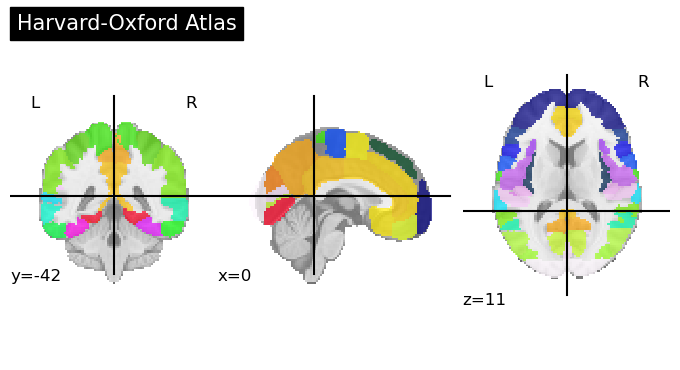

In [9]:
# Load the Harvard-Oxford Atlas
atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img = nib.load(atlas.filename)

# Plot the Harvard-Oxford Atlas without a background image
plotting.plot_roi(atlas_img, title='Harvard-Oxford Atlas', display_mode='ortho', draw_cross=True)
plt.show()

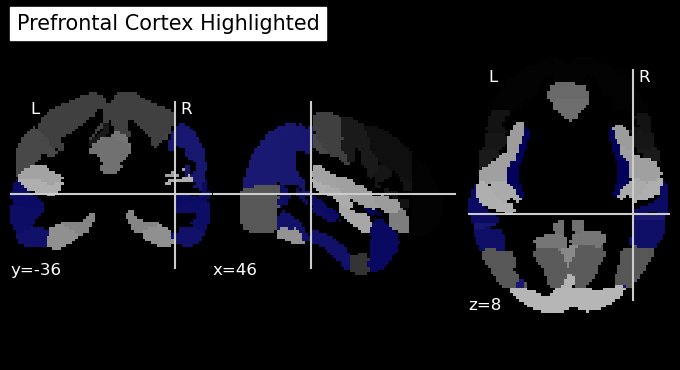

In [14]:
# Load the Harvard-Oxford Atlas
atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img = nib.load(atlas.filename)
atlas_data = atlas_img.get_fdata()

# Define label indices for the prefrontal cortex regions
prefrontal_labels = [
    2,  # Frontal Pole
    3,  # Insular Cortex
    8,  # Middle Frontal Gyrus
    10, # Inferior Frontal Gyrus, pars opercularis
    11, # Inferior Frontal Gyrus, pars triangularis
    12, # Inferior Frontal Gyrus, pars orbitalis
    13, # Frontal Operculum Cortex
    15, # Frontal Medial Cortex
    16, # Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
    20, # Paracingulate Gyrus
    21, # Cingulate Gyrus, anterior division
    22, # Cingulate Gyrus, posterior division
]

# Create a mask for the prefrontal cortex regions
prefrontal_mask_data = np.isin(atlas_data, prefrontal_labels).astype(np.uint8)
prefrontal_mask_img = nib.Nifti1Image(prefrontal_mask_data, atlas_img.affine)

# Plot the prefrontal cortex regions
plotting.plot_roi(prefrontal_mask_img, bg_img=atlas_img, title='Prefrontal Cortex Highlighted', display_mode='ortho', draw_cross=True)
plt.show()

Regional Homogeneity(ReHo)

In [6]:
# Define paths to the data and masks
data_asd_path = 'rest_denoised_asd.nii.gz'
data_adhd_path = 'rest_denoised_adhd.nii.gz'

# Load the functional data
asd_img = nib.load(data_asd_path)
adhd_img = nib.load(data_adhd_path)
asd_data = asd_img.get_fdata()
adhd_data = adhd_img.get_fdata()

# Apply Gaussian smoothing
fwhm = 6
smoothed_asd_img = smooth_img(asd_img, fwhm)
smoothed_adhd_img = smooth_img(adhd_img, fwhm)
smoothed_asd_data = smoothed_asd_img.get_fdata()
smoothed_adhd_data = smoothed_adhd_img.get_fdata()

# Define a function to calculate ReHo
def calculate_reho(data, neighbor_kernel):
    # Ensure data is at least 4D
    if data.ndim < 4:
        raise ValueError("Input data must be at least 4D (3D spatial + 1D time).")
    # Calculate the mean time series within the kernel for each voxel
    kernel_sum = np.sum(neighbor_kernel)
    local_mean = convolve(data, neighbor_kernel[..., np.newaxis], mode='constant', cval=0.0) / kernel_sum
    # Compute the local coherence (ReHo)
    reho_map = (data * local_mean).sum(axis=-1) / (np.linalg.norm(data, axis=-1) * np.linalg.norm(local_mean, axis=-1))
    return reho_map

# Define a 3x3x3 neighborhood kernel
neighbor_kernel = np.ones((3, 3, 3))

# Calculate ReHo for ASD and ADHD
reho_asd = calculate_reho(smoothed_asd_data, neighbor_kernel)
reho_adhd = calculate_reho(smoothed_adhd_data, neighbor_kernel)

# Save the ReHo maps
nib.save(nib.Nifti1Image(reho_asd, asd_img.affine), 'reho_asd.nii.gz')
nib.save(nib.Nifti1Image(reho_adhd, adhd_img.affine), 'reho_adhd.nii.gz')

print("ReHo calculation complete. Results saved as 'reho_asd.nii.gz' and 'reho_adhd.nii.gz'.")

ReHo calculation complete. Results saved as 'reho_asd.nii.gz' and 'reho_adhd.nii.gz'.


In [9]:

# Load the ReHo images
reho_asd_path = 'reho_asd.nii.gz'
reho_adhd_path = 'reho_adhd.nii.gz'

reho_asd_img = nib.load(reho_asd_path)
reho_adhd_img = nib.load(reho_adhd_path)

# Resample ADHD ReHo image to match the ASD ReHo image
resampled_adhd_img = resample_to_img(reho_adhd_img, reho_asd_img, interpolation='nearest')

# Save the resampled ADHD ReHo image
resampled_adhd_path = 'resampled_reho_adhd.nii.gz'
nib.save(resampled_adhd_img, resampled_adhd_path)

print(f"Resampled ADHD ReHo image saved at: {resampled_adhd_path}")

Resampled ADHD ReHo image saved at: resampled_reho_adhd.nii.gz
